In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance

from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader
from hnmchallenge.dataset import Dataset
from hnmchallenge.evaluation.python_evaluation import map_at_k, recall_at_k
from hnmchallenge.feature_manager import FeatureManager
from hnmchallenge.filtered_dataset import FilterdDataset
from hnmchallenge.models.ease.ease import EASE
from hnmchallenge.models.itemknn.itemknn import ItemKNN
from hnmchallenge.models.sgmc.sgmc import SGMC
from hnmchallenge.models.top_pop import TopPop
from hnmchallenge.stratified_dataset import StratifiedDataset

/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dataset = StratifiedDataset()
dr = DataReader()

In [3]:
base_load_path = dr.get_preprocessed_data_path() / "xgb_models"

In [4]:
MODEL_NAME = "xgb_v1.json"

In [5]:
model = xgb.XGBRanker()
model.load_model(base_load_path/MODEL_NAME)

In [6]:
from xgboost import plot_importance

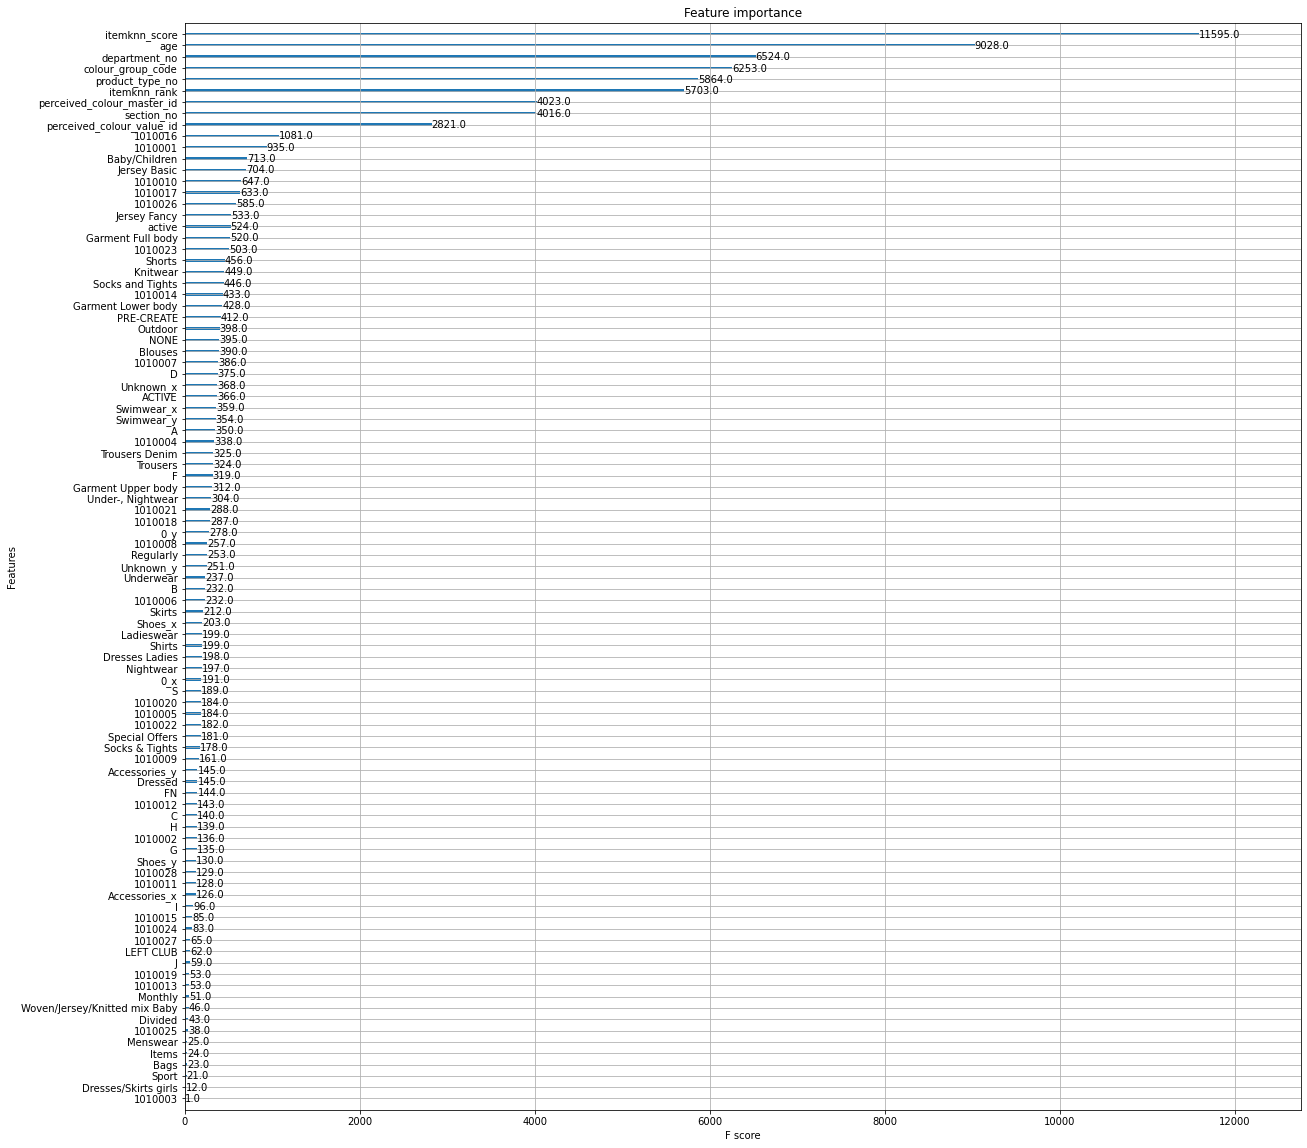

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(model, ax=ax)
plt.show()

In [8]:
model.best_ntree_limit

323

In [9]:
features = pd.read_feather(dr.get_preprocessed_data_path()/ "xgb_predictions_datasets" / "dataset_v1.feather")

# Remember to use the bert_ntree_limit when taking the predictions

In [10]:
features.head()

,customer_id,article_id,itemknn_score,itemknn_rank,colour_group_code,department_no,Accessories_x,Blouses,Dressed,Dresses Ladies,...,age,0_x,ACTIVE,LEFT CLUB,PRE-CREATE,0_y,Monthly,NONE,Regularly,FN
0,0,1482,0.010266,1,71,1747,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
1,0,1638,0.010237,2,9,1747,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
2,0,1797,0.009981,3,73,1747,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
3,0,4861,0.006984,4,9,1722,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
4,0,1652,0.006967,5,10,1643,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0


In [11]:
customer_article_df = features[[DEFAULT_USER_COL, DEFAULT_ITEM_COL]].copy()
X = features.drop([DEFAULT_USER_COL, DEFAULT_ITEM_COL], axis=1)

In [12]:
X.head()

,itemknn_score,itemknn_rank,colour_group_code,department_no,Accessories_x,Blouses,Dressed,Dresses Ladies,Dresses/Skirts girls,Jersey Basic,...,age,0_x,ACTIVE,LEFT CLUB,PRE-CREATE,0_y,Monthly,NONE,Regularly,FN
0,0.010266,1,71,1747,0,0,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
1,0.010237,2,9,1747,0,0,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
2,0.009981,3,73,1747,0,0,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
3,0.006984,4,9,1722,0,0,0,0,0,0,...,22.0,0,1,0,0,0,0,1,0,0.0
4,0.006967,5,10,1643,0,0,0,0,0,1,...,22.0,0,1,0,0,0,0,1,0,0.0


In [13]:
y_pred = model.predict(X, ntree_limit=model.best_ntree_limit)

/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
customer_article_df["predicted_score"] = y_pred

In [15]:
customer_article_df

,customer_id,article_id,predicted_score
0,0,1482,1.883024
1,0,1638,1.896487
2,0,1797,1.583541
3,0,4861,1.092821
4,0,1652,1.191469
...,...,...,...
45448235,1136205,8347,0.917366
45448236,1136205,13492,0.008108
45448237,1136205,9715,0.472525
45448238,1136205,14652,0.274132


In [16]:
sorted_scores = customer_article_df.sort_values([DEFAULT_USER_COL, "predicted_score"], ascending=False)

In [17]:
sorted_scores

,customer_id,article_id,predicted_score
45448201,1136205,7580,2.876197
45448203,1136205,838,2.637748
45448200,1136205,1765,2.490592
45448204,1136205,12955,2.328222
45448205,1136205,10033,1.881857
...,...,...,...
30,0,3847,-0.435867
34,0,1990,-0.488126
33,0,282,-0.507958
37,0,3356,-0.562894


In [18]:
sorted_scores_index = sorted_scores.reset_index(drop=True)

In [19]:
CUTOFF = 40
filter_indices = []
for i in range(len(sorted_scores_index)):
    if i % CUTOFF == 0:
        filter_indices.extend(range(i, i+12))

In [20]:
final_df = sorted_scores_index.loc[filter_indices]

In [21]:
final_df

,customer_id,article_id,predicted_score
0,1136205,7580,2.876197
1,1136205,838,2.637748
2,1136205,1765,2.490592
3,1136205,12955,2.328222
4,1136205,10033,1.881857
...,...,...,...
45448207,0,9027,0.840621
45448208,0,2375,0.616886
45448209,0,1952,0.499359
45448210,0,8422,0.382449


In [22]:
final_final_df = final_df.drop("predicted_score", axis=1)

In [23]:
from hnmchallenge.submission_handler import SubmissionHandler
sh = SubmissionHandler()                                               

In [24]:
sh.create_submission_filtered_data([final_final_df], sub_name="CUTOFF40")